In [1]:
#Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz as gr

import statsmodels.formula.api as smf

from econml.dml import LinearDML, DML

from sklearn.linear_model import LinearRegression, LogisticRegression

import pysyncon as scm

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# Abstract

In this post, we present the situation of a grocery store chain looking to decrease checkout-time by supplying scanner guns at self-checkout registers. We demonstrate first the usefulness of difference-in-differences (DiD) methodology in calculating causal effects of the intervention. We then demonstrate how to utilize synthetic control methods (SCM) to perform DiD when there is not a single suitable control unit available.

# Introduction

**My-Warehouse** (MW) is a regional warehouse club that has gained popularity along the west coast of the USA. MW has gained popularity for its bulk supply of local produce, meat, and other local specialty items from small businesses that can be bought at bulk for at a slight discount compared to other retailers. MW currently operates out of 11 stores in 11 distinct cities along the west coast. 

After analyzing customer data regarding how to improve the shopping experience in their stores, one clear suggestion came through: decrease time to checkout. With the growing popularity of MW, many new customers are anxious to get into the store and try local items. However, they become frustrated with how long they have to wait to checkout. Even with the addition of self-checkout, customers still wait too long in lines during peak hours.

One suggestion to decrease checkout time is to provide scanner guns at each self-checkout register, allowing customers to scan the items in their cart instead of unloading each item. A pilot program was recently launched in the Seattle store (SEA). We are tasked with analyzing the data from this program and recommending if the program should be launched across all stores.

# Establishing the Operations

## Understanding Optimal Efficiency with Cycle Time and Throughput Rate

To begin our analysis, we establish the current flow of traffic in the store, specifically at checkouts. To do this, we'll look at the current checkout time distribution at SEA, shown in @fig-dist-1.

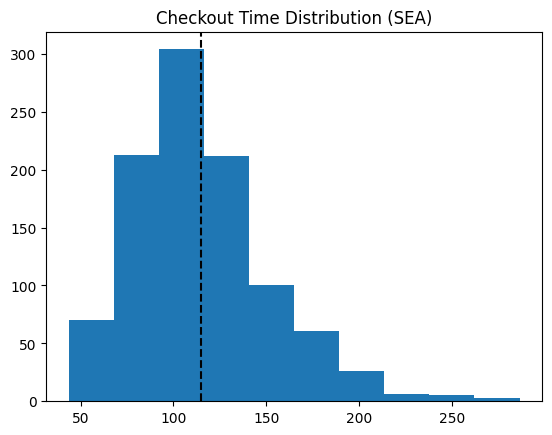

In [2]:
#| label: fig-dist-1
#| fig-cap: "Checkout time distribution in seconds for SEA store."

#Plot treatment distribution
dist = np.random.lognormal(4.7, .3, 1000)
plt.hist(dist)
plt.axvline(np.mean(dist), color='black', linestyle='dashed')
plt.title("Checkout Time Distribution (SEA)");

From @fig-dist-1, we expect a customer at the SEA store to take about 120 seconds on average to complete the checkout process. We'll assume the process of checkout to be as follows.

1. Customer scans membership card (begins timer).
2. Customer begins scanning each individual item and places item on side platform next to register.
3. After scanning all items, customer pays for items (only accepts cards at self-checkouts).
4. Customer returns all items to cart and transaction ends. 

The time to move one unit (ie one customer) through the above process is known as **cycle time (CT)**. In MW stores, there are 4 self-checkout registers available for customers to use. In the optimal scenario, each station would begin and end in parallel and the demand for each station would immediately be filled. The total output from these 4 stations over a specified time interval is defined as **throughput rate (TPR)**. The relations between CT and TPR are shown in @eq-op-1.

$$
CT = \text{average time to process one unit}
$$
$$
TPR = \frac{\text{num units produced}}{\text{total time elapsed}}
$$
$$
TPR = \frac{1}{CT}
$${#eq-op-1}

From @eq-op-1, TPR is the reciprocal of CT. Since we have CT, we know TPR must equal 1 / 120 seconds. To gain a more practical view of the operations, we'll convert this to minutes and say that our TPR is 1 / 2 minutes, or half a customer per minute is our TPR. Additionally, since we have 4 stations, we multiply this TPR by 4 to get 2 customers per minute on average. This is the assumed peak efficiency of our current system. 

## Queue Theory

In the previous section, we established the peak efficiency the system can handle through CT and TPR. One of the big assumptions we placed on this system was a steady-state flow, meaning there would be immediate demand for each station once they became free. In the real-world, steady state is nearly impossible to achieve. Additionally (and possibly more importantly for us), understanding the current wait time of customers will help us to identify how speeding up the above system can help decrease wait time. This branch of operations is known as **queue theory**.

While we will not provide an exhaustive tutorial on queue theory in this post, we will provide the necessary overview for this section. To do this, we begin with **Kendall's Notation**[@Kendall1953]. Kendall's notation provides a framework where we identify the 3 core components of queue creation, shown in @eq-op-2.

$$
A: \text{arrival process distribution (how often customers arrive)}
$$
$$
B: \text{service time distribution (how long it takes to serve a customer)}
$$
$$
C: \text{number of servers}
$${#eq-op-2}

From the previous section, we learned B (defined as our CT) and C (4 self-checkout stations). We must now identify A. Let $\lambda$ denote the average arrival rate of customers. In the context of our problem, we will suppose $\lambda$ to be the average arrival rate during our peak hours (since slow hours do not tend to have any kind of queue). The arrival distribution (which we model as a poisson distribution) is shown below in @fig-arr-1.

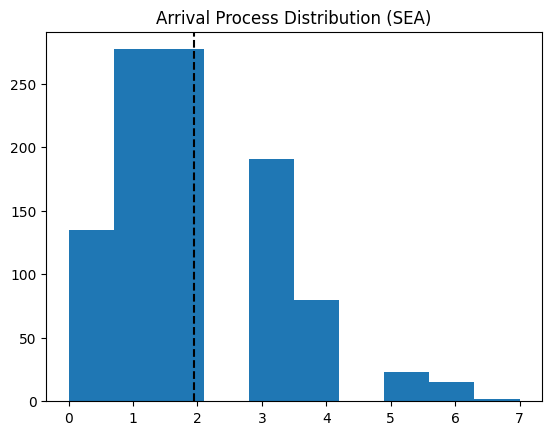

In [3]:
#| label: fig-arr-1
#| fig-cap: "Arrival distribution of customers during peak hours."

#Plot arrival distribution
dist = np.random.poisson(1.9, 1000)
plt.hist(dist)
plt.axvline(np.mean(dist), color='black', linestyle='dashed')
plt.title("Arrival Process Distribution (SEA)");

On average (during peak hours), we have about 2 customers arriving per minute. To better know the amount of time our registers are busy, we calculate **system utilization**, commonly denoted by $\rho$. The formula for $\rho$ is found in @eq-op-3.

$$
\rho = \frac{\lambda}{c\mu}
$${#eq-op-3}

System utilization is the defined as the ratio between the average arrival rate and the TPR we previously calculted. In our case, $\rho$ comes out to be .95, or 95%. According to queue theory, a system is stable if $\rho$ is < 1. Our current system is therefore stable and allows us to use **M/M/c** formulas to calculate relevant wait time and queue length metrics. The formulas used all depend on **Little's Law**[@Little1961], illustrated in @eq-op-4.

$$
L = \lambda W
$${#eq-op-4}

L represents the number of customers in the queue, $\lambda$ is the arrival rate of the customers, and W is the wait time of the customers. For our system specifically, we use an adapted version of @eq-op-4, as shown in @eq-op-5.

$$
L_{q} = \frac{P_w \rho}{1-\rho}
$${#eq-op-5}

@eq-op-5 utilizes **Erlang's formula**[@Erlang1917] to get $P_w$, which is the probability of an arriving customer having to wait in the queue. This is scaled by result of $\frac{\rho}{1-\rho}$. The result gives us the average length of the queue at any point in time (during peak hours). While we won't cover the full derivation and calculation of $P_w$, we provide that the value of it is approximately .9. Plugging this value in with our $\rho$ value, we get $L_q$ is equal to about 16.93, or about 17 people on average are waiting in the queue during peak shopping hours. That's a lot of people! 

To calculate the average time a customer waits in the queue, we utilize @eq-op-4 by rearranging the equation to solve for W. After performing some calculations, we get W is equal to 8.91 minutes. MW customers on average wait almost 9 minutes in line during peak shopping hours!

# Establishing Causality

In the previous section, we laid out the current system design of MW stores, specifically for the checkout experience. We identified through our current models that customers experience long lines (on average 17 customers in queue) and consequently long wait times (about 9 minutes waiting in queue). To address this issue in the system, MW launched a pilot program in the Seattle store to see if giving customers scanner guns at self-checkout would decrease queue wait time. Essentially, if we can decrease CT, we can increase TPR and thus move people through the queue more quickly. 

What MW is attempting to gain is **causal inference** from their intervention. MW hopes to know that if they implement this program across all their stores, then their chcekout times will decrease. The gold standard when it comes to establishing cause-effect relationships is performing a **randomized controlled trial (RCT)**. This is also known as A/B testing in some scenarios. In our scenario, we could randomly assign some stores to be control (i.e. no change in the system) and other stores to the treatment (the scanner guns). We then measure their difference in outcomes and attribute any difference in outcome to the treatment effect, assuming that the RCT was designed properly and followed the core assumptions of causal inference. 

While in theory this is the easiest route, in practice it is not always the best approach. For MW, this would mean having to buy scanner guns for $n$ number of stores that needed the treatment, without knowing if they would be going ahead with the program or not. Furthermore, training staff at each treatment location on how to implement scanner guns would also generate more costs. Identifying causal inference in business needs to be balanced with the expected costs of experiments. 

## Experiment Design 1: Difference-in-Differences

One approach we can take to help MW is to assign just one store the treatment and compare it with another store that is fairly comparable to the treated store. This approach is know as the **Difference-in-Differences (DiD)**[@Card1994Minimum] model. DiD is known as a quasi-experimental design since it doesn't rely on random assignment. Instead, it "mimics" the effects of RCTs by accounting for unobserved confounders by measuring the change in outcomes to a similar unit. Specifically, this is known as the **parallel trends** assumption. DiD assumes that both the treated unit and the control unit follow parallel trends had there not been any intervention. Mathematically, this is represented as a linear model as shown in @eq-did-1.

$$
Y_{i} = \beta_{0} + \beta_{1}SEA_{i} + \beta_{2}POST_{i} + \beta_{3}(SEA_{i}*POST_{i}) + \epsilon_{i}
$${#eq-did-1}

$Y_{i}$ is the outcome being measured (average checkout time), $SEA_{i}$ is a dummy variable indicating whether the observation is in Seattle or not. $POST_{i}$ is a dummy variable indicating whether or not the observation occurred after the intervention. We then have the interaction term where $\beta_{3}$ would show the average treatment effect between Seattle and the control city after the intervention was applied. 

To get a little more granular into how a simple OLS regression model derives causal effects from this design, consider the basic case of the potential outcomes framework[@rubin1974estimating]. We extend this to DiD by saying each observation takes on an outcome of $Y_{D}(T)$, where D is the treatment assignment (1 for Seattle and 0 for the control) and T is the time period (1 for post intervention and 0 for pre intervention). In the counterfactual world, we would be able to calculate the **average treatment effect of treated (ATT)** by computing $E[Y_{1}(1) - Y_{0}(1)|D=1]$. However, $Y_{0}(1)$ is the counterfactual for any given observation where we observe the treated in post intervention. To work around this, we replace the missing counterfactual by setting it equal to $E[Y_{0}(0)|D=1] + (E[Y_{0}(1)|D=0] - E[Y_{0}(0)|D=0])$. With a bit of rearranging to the original "preferred" equation, we arrive at @eq-did-2.

$$
ATT = (E[Y(1)| D=1] - E[Y(0)| D=1]) - (E[Y(1)| D=0] - E[Y(0)| D=0])
$${#eq-did-2}

In essence, we take the difference between the treatment post and pre intervention and the difference between the control post and pre intervention, then take the difference of those differences. Hence, we arrive at the name "difference-in-differences".

## DiD Results

Since we've now established how we can model our problem using DiD, we can now get into the results of our model. As stated previously, Seattle is the location our treatment (i.e. implementing scanner guns for check-outs). From previous analysis, we believe a good control candidate that follows our DiD assumptions would be San Francisco (SF). We collected data over 100 days from both locations. At the 50 day mark, we rolled out the scanner guns in Seattle. @fig-did-1 shows the data we collected over time at both SEA and SF.

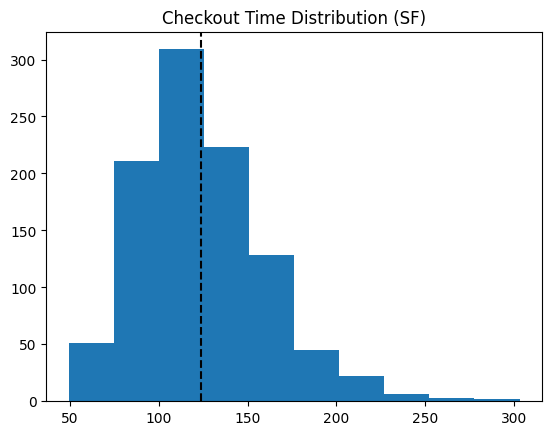

In [4]:
#| output: false

#Plot control distribution
dist = np.random.lognormal(4.8, .3, 1000)
plt.hist(dist)
plt.axvline(np.mean(dist), color='black', linestyle='dashed')
plt.title("Checkout Time Distribution (SF)");

In [5]:
#Define synthetic dataset function
def get_syn_data(
    n_t, 
    mu_treat, 
    sd_treat, 
    mu_cont, 
    sd_cont, 
    trend, 
    treat_eff_mu, 
    treat_eff_sd, 
    r_seed
):
    
    np.random.seed(r_seed)
    
    syn_dict_treat = {
        'avg_ct': [],
        'sea': [],
        'post_int': []
    }
    
    syn_dict_cont = {
        'avg_ct': [],
        'sea': [],
        'post_int': []
    }

    for i in range(n_t):
        int_bool = np.where(i > n_t / 2, True, False).item()
        trend_mul = trend * i
        treat_mul = treat_eff_mu * i
        
        ct_sea = np.where(int_bool, 
                          np.mean(np.random.lognormal(mu_treat + trend_mul  - treat_mul, sd_treat - treat_eff_sd, 100)),
                          np.mean(np.random.lognormal(mu_treat + trend_mul, sd_treat, 100))
                         ).item()
        
        ct_sf = np.mean(np.random.lognormal(mu_cont + trend_mul, sd_cont, 100))
        
        
        
        syn_dict_treat['avg_ct'].append(ct_sea)
        syn_dict_treat['sea'].append(1)
        syn_dict_treat['post_int'].append(int_bool)
        
        syn_dict_treat['avg_ct'].append(ct_sf)
        syn_dict_treat['sea'].append(0)
        syn_dict_treat['post_int'].append(int_bool)
        
    
    syn_df = pd.DataFrame({key: syn_dict_treat[key] + syn_dict_cont[key] for key in syn_dict_treat})
    
    return syn_df

In [6]:
#Generate synthetic data
df = get_syn_data(100, 4.7, .3, 4.8, .3, .001, .003, .05, 42)

In [7]:
#Show head of df
df.head()

,avg_ct,sea,post_int
0,115.429541,1,False
1,130.756135,0,False
2,113.958007,1,False
3,122.035513,0,False
4,114.782158,1,False


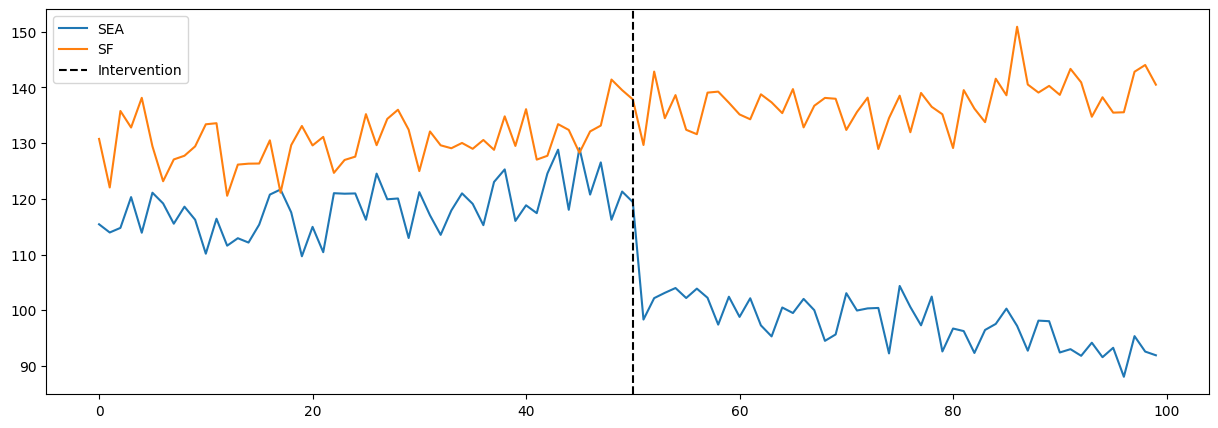

In [8]:
#| label: fig-did-1
#| fig-cap: "Seattle vs San Francisco average checkout time over 100 days."

#Plot trends
fig, ax = plt.subplots(figsize=(15,5))

ax.plot(df.query("sea == 1")['avg_ct'].reset_index(drop=True), label='SEA')
ax.plot(df.query("sea == 0")['avg_ct'].reset_index(drop=True), label='SF')
ax.axvline(50, color='black', linestyle='dashed', label='Intervention')
ax.legend();

From @fig-did-1, we see that SEA and SF follow similar trends up till time of intervention. When the scanner guns are implemented, there is a sharp decrease in average check-out time with a continual downward trend. This is a great indication that our program provided significant decrease to CT. To get a numerical value from this graph, we can extract it manually by performing the above calculations using the data or by fitting a OLS model (they both provide the same result. Below we provide both results.

In [9]:
#Show "true" DiD estimate
sea_before = df.query("sea == 1 and post_int == 0")['avg_ct'].mean()
sea_after = df.query("sea == 1 and post_int == 1")['avg_ct'].mean()
sf_before = df.query("sea == 0 and post_int == 0")['avg_ct'].mean()
sf_after = df.query("sea == 0 and post_int == 1")['avg_ct'].mean()

print(f"True DiD Estimate: {(sea_after - sea_before) - (sf_after - sf_before)}")

True DiD Estimate: -27.421232456603718


In [10]:
#Fit DiD and show results
smf.ols('avg_ct ~ sea * post_int', data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,130.4273,0.607,214.823,0.000,129.230,131.625
post_int[T.True],6.8350,0.867,7.880,0.000,5.125,8.546
sea,-12.1969,0.859,-14.205,0.000,-13.890,-10.504
sea:post_int[T.True],-27.4212,1.227,-22.355,0.000,-29.840,-25.002


The added value we gain from fitting the OLS is that we gain SE estimates and subsequent CI estimates. According to our model, scanner guns provide an on average decrease of about 27 seconds. Recalling what we calculated in the operations section, our new CT would be approximately 93 seconds. This means our new TPR would be approximately 2.58 customers per minute (a 29% increase in TPR). This results in a change in system utilization from 95% to about 74%. From here, we calculate our average queue length to be 1.36 customers (a 92% decrease in average queue length!) which then results in average wait time in the queue to be about 43 seconds (or .715 minutes, also a 92% decrease!).  

According to our models, the scanner guns are a huge success and represent a major opportunity for MW to increase customer satisfaction through higher operational efficiency. While we did derive useful causal effects from this experiment, MW should obviously consider other factors like feasability of company wide adoption, cost and maintenance of the equipment, and potential other factors like increases in theft from not scanning all items. 

In [11]:
#| output: false

#Use DML
model_y = LinearRegression()
model_t = LinearRegression()
est = LinearDML(model_y=model_y, model_t=model_t)
est.fit(Y=df['avg_ct'], T=df['sea'] * df['post_int'], W=df[['post_int', 'sea']], X=None)

Not all column names are strings. Coercing to strings for now.


In [12]:
#| output: false

#Provide DML estimate
print(f"DML ATE: {est.ate(X=None)}")
print(f"DML CI: {est.ate_interval(X=None)}")

DML ATE: -28.232404303405858
DML CI: (-30.53107723993472, -25.933731366876994)


## Experimental Design 2: Synthetic Control

As explained in the DiD section, one of the key assumtions behind the DiD model is the parallel trends assumption. In order for our model to be valid, we need to find an adequate enough control unit that follows a close enough parallel trend, along with the other usual assumptions of causality. This assumption is regularly broken in the real world as it is difficult to find a control unit that satisfies the model assumptions.

Instead of attempting to find a single control unit to compare our control to, we can "create" our own control by using **synthetic control methods**[@Abadie2003]. We create a synthetic control by taking a weighted average of all our possible controls (i.e. our donor pool) that best mimics the pre-intervention behavior of our treatment unit. An popular example of this is also found in [@Abadie2010] where the authors used SCM to model the effect of Califronia's tobacco tax policy. 

In our example, we would take a weighted average of our other 10 stores to form a synthetic control to compare against Seattle. Let's quickly walk through what the math looks like in SCM. 

SCM attempts to estimate the counterfactual $Y_{t}^{N}$, that is, the response of our treatment unit had the intervention never happened (i.e. the response of Seattle had it never received scanner guns). SCM estimates this counterfactual through a weighted average across the responses of the donor pool, as shown in @eq-scm-1.

$$
Y_{t}^{N} \approx \sum_{j=2}^{J+1} w_{j} Y_{jt}
$${#eq-scm-1}

The weights are calculated by finding the minimum distance between $X_{1}$ (the pre-intervention characteristics of the treated unit) and $X_{0}W$ (the pre-intervention characteristics of a control unit). This minimization is subject to two constraints: all weights must be greater than or equal to 0 and all weights must sum to 1. Once these weights are calculated, they are applied to the post-intervention responses of the control units. The distance between the treated unit and the synthetic control is then the estimated ATT.

In [13]:
#Define SCM synthetic dataset function
def get_scm_data(
    n_t,
    n_donors,
    mu_treat, 
    sd_treat, 
    trend, 
    treat_eff_mu, 
    treat_eff_sd, 
    r_seed
):
    
    np.random.seed(r_seed)
    
    syn_data_dict = {
        'city': [],
        'day_num': [],
        'avg_ct': [],
        'avg_age': [],
        'pct_2nd_card': [],
        'sea': [],
        'post_int': []
    }
    
    avg_age = 30
    age_eff_treat = .05 * avg_age
    card_eff_treat = .3
    
    
    for i in range(n_t):
        int_bool = np.where(i > n_t / 2, True, False)
        trend_mul = trend * i
        treat_mul = treat_eff_mu * i
        
        pct_2nd_card = np.mean(np.random.beta(3, 2, 100))
        card_eff_treat_2 = card_eff_treat * pct_2nd_card
        
        ct_sea = np.where(int_bool, 
                          np.mean(np.random.lognormal(mu_treat + trend_mul  - treat_mul + age_eff_treat + card_eff_treat_2, 
                                                      sd_treat - treat_eff_sd, 100)),
                          np.mean(np.random.lognormal(mu_treat + trend_mul + age_eff_treat + card_eff_treat_2, sd_treat, 100))
                         ).item()
        
        
        
        syn_data_dict['city'].append(0)
        syn_data_dict['day_num'].append(i)
        syn_data_dict['avg_ct'].append(ct_sea)
        syn_data_dict['avg_age'].append(avg_age)
        syn_data_dict['pct_2nd_card'].append(pct_2nd_card)
        syn_data_dict['sea'].append(True)
        syn_data_dict['post_int'].append(int_bool)
        
    
    for i in range(1, n_donors+1):
        temp_avg_age = avg_age + np.random.randint(-2, 2)
        mu_cont = mu_treat + np.random.uniform(-.1, .1)
        sd_cont = sd_treat
        alpha = np.random.uniform(2, 4)
        beta = np.random.uniform(2, 4)
        age_eff_cont = .05 * temp_avg_age
        card_eff_cont = np.random.uniform(.2, .3)
        
        for j in range(n_t):
            int_bool = np.where(j > n_t / 2, True, False)
            trend_mul = trend * j
            
            pct_2nd_card = np.mean(np.random.beta(alpha, beta, 100))
            card_eff_cont_2 = card_eff_cont * pct_2nd_card
            
            ct_cont = np.mean(np.random.lognormal(mu_cont + trend_mul + age_eff_cont + card_eff_cont_2, sd_cont, 100))
            
        
            syn_data_dict['city'].append(i)
            syn_data_dict['day_num'].append(j)
            syn_data_dict['avg_ct'].append(ct_cont)
            syn_data_dict['avg_age'].append(temp_avg_age)
            syn_data_dict['pct_2nd_card'].append(pct_2nd_card)
            syn_data_dict['sea'].append(False)
            syn_data_dict['post_int'].append(int_bool)
    
    return pd.DataFrame(syn_data_dict)
            

In [14]:
#Generate SCM data
num_donors = 10
scm_df = get_scm_data(100, num_donors, 3.1, .3, .001, .002, .01, 42)

In [15]:
#Create SCM object
scm_mod = scm.Synth()

In [16]:
#| output: false

scm_df

,city,day_num,avg_ct,avg_age,pct_2nd_card,sea,post_int
0,0,0,119.063055,30,0.608298,True,False
1,0,1,129.962777,30,0.597219,True,False
2,0,2,126.868552,30,0.573204,True,False
3,0,3,124.692327,30,0.586221,True,False
4,0,4,124.286452,30,0.599149,True,False
...,...,...,...,...,...,...,...
1095,10,95,110.060645,28,0.475283,False,True
1096,10,96,107.048006,28,0.434631,False,True
1097,10,97,110.952709,28,0.465210,False,True
1098,10,98,107.655052,28,0.451540,False,True


In our analysis, we used `pysyncon`[@pysyncon] to create our synthetic control. After preparing our data for it, we obtained the following weights.

In [17]:
#Create dataprep object
data_prep = scm.Dataprep(foo=scm_df, predictors=['avg_age', 'pct_2nd_card'], 
             predictors_op='mean', 
             dependent='avg_ct', 
             unit_variable='city', 
             time_variable='day_num', 
             treatment_identifier=0, 
             controls_identifier=np.arange(1,num_donors+1).tolist(),
             time_predictors_prior=np.arange(0, 100).tolist(),
             time_optimize_ssr=np.arange(0, 100).tolist())

In [18]:
#Fit SCM
scm_mod.fit(dataprep=data_prep, optim_method="BFGS", optim_initial="ols")

In [19]:
#Check weights
scm_mod.weights()

1     0.028
2     0.000
3     0.000
4     0.000
5     0.297
6     0.000
7     0.000
8     0.525
9     0.149
10    0.000
Name: weights, dtype: float64

As we can see, the closest city is city 8, followed by city 5, 9, and 1. The rest of the cities are not included in the weighted average. The plot of our synthetic control vs treated is found below in @fig-scm-1.

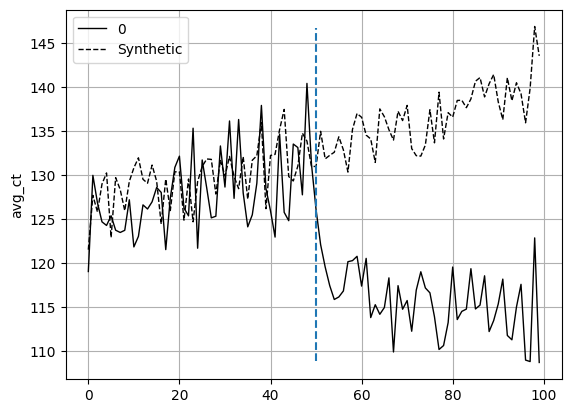

In [20]:
#| label: fig-scm-1
#| fig-cap: "Seattle vs Synthetic control over time."

#Show path plot
scm_mod.path_plot(time_period=np.arange(0, 100).tolist(), treatment_time=50)

Our SC appears to follow the trajectory and variation of Seattle fairly well (in a real SCM, we'd want it better but this suffices for this analysis). As such, when the intervention occurs, we can estimate the ATT via the distance between these two units. The distance overtime between these two are shown in @fig-scm-2. The ATT immediately follows below it. 

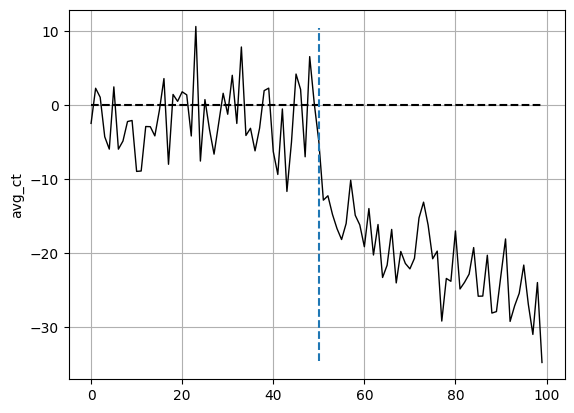

In [21]:
#| label: fig-scm-2
#| fig-cap: "Gap plot for Seattle vs Synthetic control."

#SHow gap plot
scm_mod.gaps_plot(time_period=np.arange(0, 100).tolist(), treatment_time=50)

In [22]:
#Show ATT
scm_mod.att(time_period=np.arange(50, 100).tolist())

{'att': -20.67706963332358, 'se': 0.8177388666624705}

From both @fig-scm-1 and @fig-scm-2, as well as the estimated ATT, the scanner guns appear to be a viable program for MW. Since we covered the effects on the operational efficiecny of this program in the previous experiment, we won't go through it as detailed here. As mentioned earlier and as noticed in @fig-scm-2, we'd want to aim for a better SC to avoid the huge spikes in distance from the treated unit pre-intervention. 

In [23]:
#| output: false

#Show summary
scm_mod.summary()

,V,treated,synthetic,sample mean
avg_age,0.791,30.000,29.999,29.900
pct_2nd_card,0.209,0.599,0.599,0.513


# Conclusion

In this post, we walked through how operation research principles can help us establish a foundational model on how the customer experience is for checkouts in MW. We calculated baseline metrics for how long it takes for customers to go through the queue and through checkout. We then analyzed the effects of a potential solution of using scanner guns to speed up the checkout process. We used DiD and SCM to calculate these causal effects as well as the potential changes in operational efficiency this program would provide. The next steps of this analysis in a proper business setting would include cost-benefit analysis, customer sentiment analysis from the pilot store, and if accepted, implementation protocols for the rest of the stores. Overall, this analysis provided a solid foundation on how causal inference can be utilized to enhance operational efficiency. 